In [3]:
import numpy as np 
import pandas as pd 
from keras.models import Model, load_model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
sns.set_style('darkgrid')

In [4]:
#Check versions of keras, tensorflow, python and numpy
import keras
import tensorflow as tf
import sys
import sklearn
print('Python version:', sys.version)
print('Keras version:', keras.__version__)
print('Tensorflow version:', tf.__version__)
print('Numpy version:', np.__version__)
print('sklearn version:', sklearn.__version__)


Python version: 3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]
Keras version: 2.15.0
Tensorflow version: 2.15.0
Numpy version: 1.26.4
sklearn version: 1.4.1.post1


In [6]:
#load the numpy arrays from disk
X_train = np.load('./X_train.npy')
X_val = np.load('./X_val.npy')
X_test = np.load('./X_test.npy')
y_train = np.load('./y_train.npy')
y_val = np.load('./y_val.npy')
y_test = np.load('./y_test.npy')

In [4]:
#model = load_model('/media/amendoza/HDD/ECG LVAD candidacy/single_lead_Model/single-lead-model24_2_22.keras')

In [7]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Add, Activation, Softmax
from keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder

#Converting to one hot encoding
ohe = OneHotEncoder(sparse_output=False)
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_val = ohe.fit_transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

batch_size = 96
feature = 187
depth = 1

def model_builder(num_filters, pool_size, kernel_size, dense_units1, dense_units2):
    hp_num_filters = num_filters
    hp_max_pool_size = pool_size
    hp_kernel_size = kernel_size
    hp_dense_1 = dense_units1
    hp_dense_2 = dense_units2
    
    inp = Input(shape=(feature, depth))
    C = Conv1D(filters=hp_num_filters, kernel_size=hp_kernel_size, strides=1)(inp)

    C11 = Conv1D(filters=hp_num_filters, kernel_size=hp_kernel_size, strides=1, padding='same')(C)
    A11 = Activation("relu")(C11)
    C12 = Conv1D(filters=hp_num_filters, kernel_size=hp_kernel_size, strides=1, padding='same')(A11)
    S11 = Add()([C12, C])
    A12 = Activation("relu")(S11)
    M11 = MaxPooling1D(pool_size=hp_max_pool_size, strides=2)(A12)


    C21 = Conv1D(filters=hp_num_filters, kernel_size=hp_kernel_size, strides=1, padding='same')(M11)
    A21 = Activation("relu")(C21)
    C22 = Conv1D(filters=hp_num_filters, kernel_size=hp_kernel_size, strides=1, padding='same')(A21)
    S21 = Add()([C22, M11])
    A22 = Activation("relu")(S21)
    M21 = MaxPooling1D(pool_size=hp_max_pool_size, strides=2)(A22)


    C31 = Conv1D(filters=hp_num_filters, kernel_size=hp_kernel_size, strides=1, padding='same')(M21)
    A31 = Activation("relu")(C31)
    C32 = Conv1D(filters=hp_num_filters, kernel_size=hp_kernel_size, strides=1, padding='same')(A31)
    S31 = Add()([C32, M21])
    A32 = Activation("relu")(S31)
    M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


    C41 = Conv1D(filters=hp_num_filters, kernel_size=hp_kernel_size, strides=1, padding='same')(M31)
    A41 = Activation("relu")(C41)
    C42 = Conv1D(filters=hp_num_filters, kernel_size=hp_kernel_size, strides=1, padding='same')(A41)
    S41 = Add()([C42, M31])
    A42 = Activation("relu")(S41)
    M41 = MaxPooling1D(pool_size=hp_max_pool_size, strides=2)(A42)


    C51 = Conv1D(filters=hp_num_filters, kernel_size=hp_kernel_size, strides=1, padding='same')(M41)
    A51 = Activation("relu")(C51)
    C52 = Conv1D(filters=hp_num_filters, kernel_size=hp_kernel_size, strides=1, padding='same')(A51)
    S51 = Add()([C52, M41])
    A52 = Activation("relu")(S51)
    M51 = MaxPooling1D(pool_size=hp_max_pool_size, strides=2)(A52)

    F1 = Flatten()(M51)

    D1 = Dense(hp_dense_1)(F1)  
    A6 = Activation("relu")(D1)
    D2 = Dense(hp_dense_2)(A6) 
    D3 = Dense(7)(D2)  
    A7 = Softmax()(D3)

    model = Model(inputs=inp, outputs=A7)
    #model.summary()
    adam = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999)
    metrics = ['binary_accuracy', 'AUC']
    model.compile(loss='categorical_crossentropy', 
              optimizer=adam, metrics=metrics)
    return model

model = model_builder (num_filters=64, pool_size=5, kernel_size=5, dense_units1=64, dense_units2=32)

history = model.fit(X_train, y_train, 
                    epochs=5,
                    batch_size=batch_size, 
                    verbose=1, 
                    validation_data=(X_val, y_val), 
                    #callbacks=callbacks
                   )




Epoch 1/5


2082/2082 [==============================] - 97s 45ms/step - loss: 0.4567 - binary_accuracy: 0.9558 - auc: 0.9817 - val_loss: 0.2792 - val_binary_accuracy: 0.9732 - val_auc: 0.9909
Epoch 2/5
2082/2082 [==============================] - 92s 44ms/step - loss: 0.2038 - binary_accuracy: 0.9803 - auc: 0.9953 - val_loss: 0.3092 - val_binary_accuracy: 0.9712 - val_auc: 0.9892
Epoch 3/5
2082/2082 [==============================] - 99s 48ms/step - loss: 0.1467 - binary_accuracy: 0.9860 - auc: 0.9972 - val_loss: 0.1733 - val_binary_accuracy: 0.9833 - val_auc: 0.9960
Epoch 4/5
2082/2082 [==============================] - 97s 46ms/step - loss: 0.1118 - binary_accuracy: 0.9896 - auc: 0.9981 - val_loss: 0.1482 - val_binary_accuracy: 0.9855 - val_auc: 0.9969
Epoch 5/5
2082/2082 [==============================] - 95s 46ms/step - loss: 0.0905 - binary_accuracy: 0.9916 - auc: 0.9985 - val_loss: 0.1741 - val_binary_accuracy: 0.9837 - val_auc: 0.9956


In [8]:
y_pred = model.predict(X_test, batch_size=1000)

8/8 [==============================] - 1s 114ms/step


In [9]:
# from sklearn.preprocessing import OneHotEncoder

# #Convert y to one hot encoding 
# ohe = OneHotEncoder(sparse_output=False)
# y_train = ohe.fit_transform(y_train.reshape(-1,1))
# y_val = ohe.fit_transform(y_val.reshape(-1,1))
# y_test = ohe.transform(y_test.reshape(-1,1))

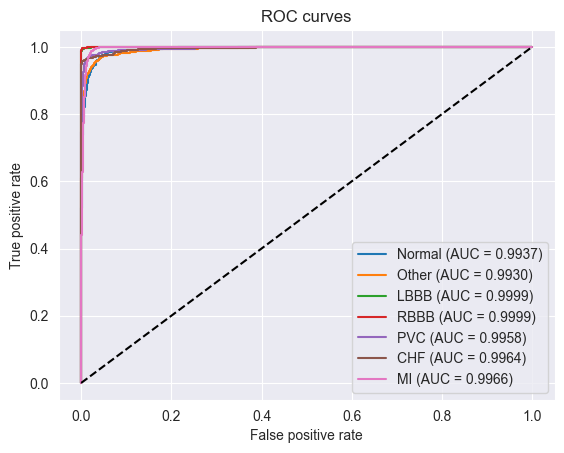

In [10]:

from sklearn.metrics import roc_curve, roc_auc_score
n_classes = 7
class_names = ['Normal','Other','LBBB','RBBB', 'PVC', 'CHF', 'MI']
# plot ROC curves for each class
for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_pred[:, i])
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc:.4f})')

# plot random guessing line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves')
plt.legend()
plt.show()

In [14]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1039
           1       0.92      0.92      0.92      1039
           2       1.00      0.99      0.99      1039
           3       1.00      0.99      0.99      1039
           4       0.98      0.89      0.93      1039
           5       0.99      0.96      0.97      1044
           6       0.95      0.83      0.89      1057

    accuracy                           0.94      7296
   macro avg       0.94      0.94      0.94      7296
weighted avg       0.94      0.94      0.94      7296



In [16]:
model.save('interence_model.keras')

In [17]:
# Convert Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('interence_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\praha\AppData\Local\Temp\tmp03trlb1a\assets


INFO:tensorflow:Assets written to: C:\Users\praha\AppData\Local\Temp\tmp03trlb1a\assets
